In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math
from sklearn import datasets
from scipy import stats as st
import pandas as pd

In [ ]:
image_name = 'road'
image_path = 'Project_Source/' + image_name + '.jpg'
cluster_value = 16
k_means_smooth_kernel_size = 5
second_smooth_value_kernel_size = 7
should_show_windows = False

In [ ]:
def read_image(path):
    img = cv2.imread(path)
     
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
    return img

In [ ]:
def show_image(image, x_size = 25, y_size = 15):
    f = plt.figure()
    f.set_figwidth(x_size)
    f.set_figheight(y_size)

    plt.imshow(image.astype(np.uint8))
    plt.show()


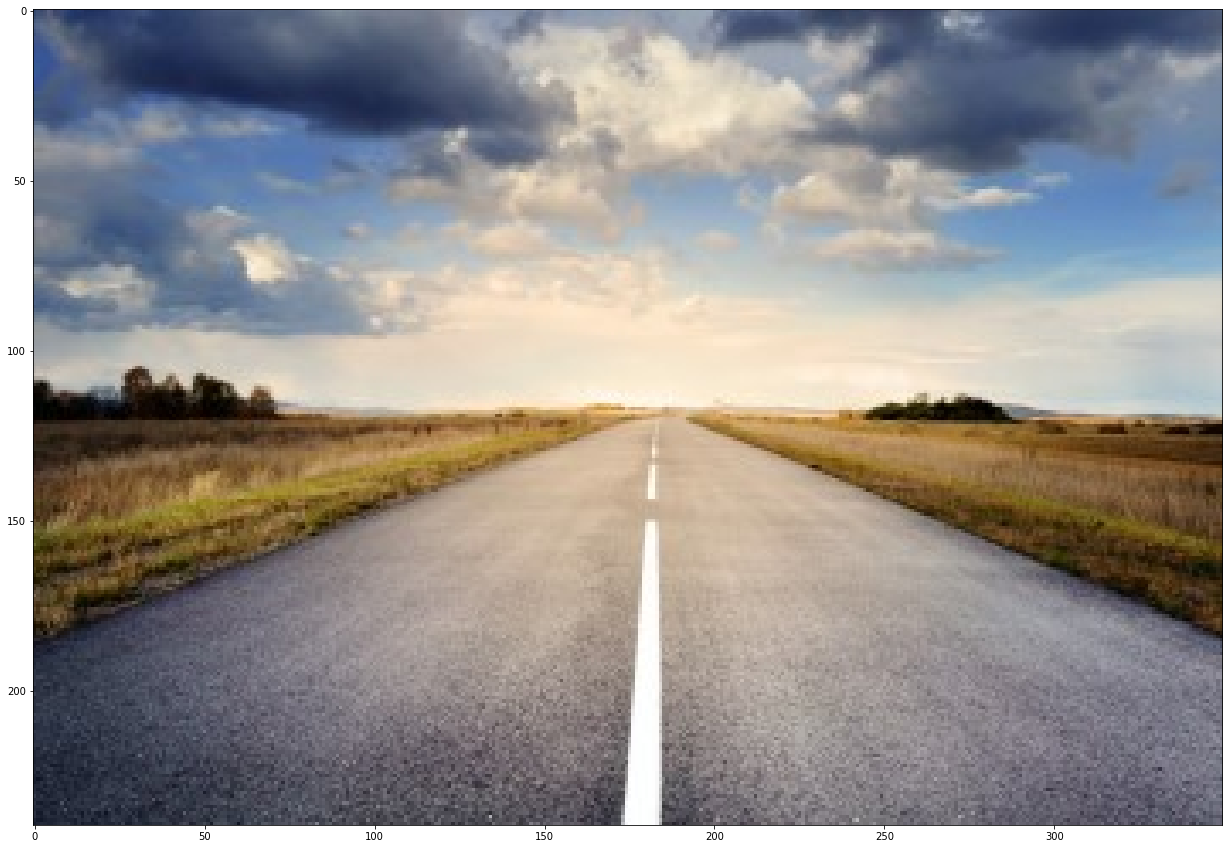

In [ ]:
image = read_image(image_path)
show_image(image)

In [ ]:
def pick_random_centroids(image, k) -> dict:
    # print(image)
    width = image.shape[0]
    height = image.shape[1]
    xmin = 255
    ymin = 255
    zmin = 255
    xmax = 0
    ymax = 0
    zmax = 0
    for x in range(0, width):
        for y in range(0, height):
            if image[x,y][0] < xmin:
                xmin = image[x,y][0]
            if image[x,y][1] < ymin:
                ymin = image[x,y][1]
            if image[x,y][2] < zmin:
                zmin = image[x,y][2]
            if image[x,y][0] > xmax:
                xmax = image[x,y][0]
            if image[x,y][0] > ymax:
                ymax = image[x,y][1]
            if image[x,y][2] > zmax:
                zmax = image[x,y][2]

    # print(xmin, xmax, ymin, ymax, zmin, zmax)
    clusters_centroids = {}
    for i in range (0,k):
        #print(image.shape)
        clusters_centroids[str(i)] = np.array([random.randint(xmin, xmax), random.randint(ymin, ymax), random.randint(zmin, zmax)])
    
    print(clusters_centroids)

    return clusters_centroids

In [ ]:
def find_closest_centroid(point, clusters_centroids, dim = 3) -> int:
    result = 0
    min_distance = float('inf')
    distance = 0
    for cluster_num, centroid in clusters_centroids.items():
        if dim == 3:
            distance = ((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2 + (point[2] - centroid[2])**2)**0.5
        if dim == 2:
            distance = ((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2)**0.5
        #print((point[0] - centroid[0])**2, (point[1] - centroid[1])**2,  (point[2] - centroid[2])**2, distance)
        if distance < min_distance:
            result = cluster_num
            min_distance = distance

    return result

In [ ]:
def Create_pixel_by_index(image, indexes, clusters_num):
    # print('recalculate_centroids')
    width = image.shape[0]
    height = image.shape[1]

    pixel_by_index = dict.fromkeys([str(i) for i in range(0, clusters_num)], np.array([]))
    # print(pixel_by_index)

    for k in range(0, width):
        for j in range (0, height):
            if len(pixel_by_index[str(int(indexes[k, j]))]) == 0:
                pixel_by_index[str(int(indexes[k, j]))] = np.reshape(image[k, j], (1, -1))
            else:
                pixel_by_index[str(int(indexes[k, j]))] = np.concatenate([pixel_by_index[str(int(indexes[k, j]))], np.reshape(image[k, j], (1, -1))])
    # print('end recalculate_centroids')
    return pixel_by_index

In [ ]:
def recalculate_centroids(image, indexes, clusters_num, old_centroids):
    # pixel_by_index = Create_pixel_by_index(image, indexes, clusters_num)
    # print(pixel_by_index)
    clusters_centroids = {}

    pixel_sum_and_count_by_index = dict.fromkeys([str(i) for i in range(0, clusters_num)])
    # print(list(pixel_sum_and_count_by_index.keys()))
    for cluster in list(pixel_sum_and_count_by_index.keys()):
        pixel_sum_and_count_by_index[cluster] = [0,0,0,0]
    
    # print(pixel_sum_and_count_by_index)
    width = image.shape[0]
    height = image.shape[1]

    # pixel_by_index = dict.fromkeys([str(i) for i in range(0, clusters_num)], np.array([]))
    # print(pixel_by_index)
    for x in range(0, width):
        for y in range (0, height): 
            pixel_sum_and_count_by_index[str(int(indexes[x,y]))][0] += image[x,y][0]
            pixel_sum_and_count_by_index[str(int(indexes[x,y]))][1] += image[x,y][1]
            pixel_sum_and_count_by_index[str(int(indexes[x,y]))][2] += image[x,y][2]
            pixel_sum_and_count_by_index[str(int(indexes[x,y]))][3] += 1
 
    # print(pixel_sum_and_count_by_index)
    need_another_iteraction = False
    clusters_centroids = dict.fromkeys([str(i) for i in range(0, clusters_num)], [])

    for k in range(0, clusters_num):
        pixel = pixel_sum_and_count_by_index[str(k)]
        clusters_centroids[str(k)] = np.array([pixel[0], pixel[1], pixel[2]]) // pixel[3]

        if not np.array_equal(old_centroids[str(k)], clusters_centroids[str(k)]):
            need_another_iteraction = True
    
    print(clusters_centroids)
    return clusters_centroids, need_another_iteraction
    

In [ ]:
def k_means_apply(image, k):
    iterations = 50
    width = image.shape[0]
    height = image.shape[1]
    centroids = pick_random_centroids(image, k)
    # print(centroids)
    clusters = []
    index_image = np.zeros((width, height))

    while iterations > 0:
        print('iterations: ', iterations)
        for x in range(0, width):
            for y in range (0, height):
                cluster = find_closest_centroid(image[x, y], centroids)
                index_image[x, y] = cluster
                if cluster not in clusters:
                    clusters.append(cluster)
        
        # print(centroids)
        # print(index_image)
        centroids, need_another_iteraction = recalculate_centroids(image, index_image, k, centroids)
        if not need_another_iteraction:
            print('remained iterations: ', iterations)
            break

        iterations -= 1

    k_mean_image = image.copy()
    for x in range(0, width):
        for y in range (0, height):
            k_mean_image[x, y] = centroids[str(int(index_image[x,y]))]

    print(centroids)
    return k_mean_image, index_image, centroids


In [ ]:
def k_means_score(image, index_image, clusters):
    width = image.shape[0]
    height = image.shape[1]
    # iterator = 0
    score : float = 0
    for x in range(0, width):
        for y in range (0, height):
            # if iterator % 100 == 1:
            #     print('score: ', score)
            point = image[x,y]
            # print(clusters, index_image[x,y])
            centroid = clusters[str(int(index_image[x,y]))]
            
            distance = float(((float(point[0]) - float(centroid[0]))**2 + (float(point[1]) - float(centroid[1]))**2 + (float(point[2]) - float(centroid[2]))**2)**0.5)  / 10000
            # print(type(distance), type(score), point, centroid, type(point))

            score = score + distance

            # iterator += 1
    # print(score)
    return score

In [ ]:
def k_means(image, k):
    iterations = 1
    result_score = float('inf')
    result_image = image.copy()
    result_clusters = {}
    while iterations > 0:
        print('iterations remained: ', iterations)
        k_mean_image, index_image, centroids = k_means_apply(image, k)
        score = k_means_score(image, index_image, centroids)
        if result_score > score:
            print('result_score > score: ', score)
            result_score = score
            result_image = k_mean_image.copy()
            result_clusters = centroids.copy()
        
        iterations -= 1
    
    return result_image, result_clusters

# print(index_image)

In [ ]:
k_mean_image, clusters = k_means(image, cluster_value)

iterations remained:  1
{'0': array([ 14, 162,  58]), '1': array([128, 148,  65]), '2': array([ 15, 153,  80]), '3': array([138, 156, 115]), '4': array([247, 141,  60]), '5': array([ 92, 233, 226]), '6': array([104, 109, 231]), '7': array([45, 10, 79]), '8': array([209, 137,  72]), '9': array([76, 80, 58]), '10': array([154,  95, 109]), '11': array([ 34, 125, 114]), '12': array([204,  98,   2]), '13': array([ 28, 245, 104]), '14': array([179,  65,  35]), '15': array([  9,  38, 228])}
iterations:  50


C:\Users\Rybak\AppData\Local\Temp/ipykernel_3888/3073712055.py:30: RuntimeWarning: divide by zero encountered in floor_divide
  clusters_centroids[str(k)] = np.array([pixel[0], pixel[1], pixel[2]]) // pixel[3]


{'0': array([0, 0, 0], dtype=int32), '1': array([145, 113,  56], dtype=int32), '2': array([0, 0, 0], dtype=int32), '3': array([171, 166, 162], dtype=int32), '4': array([244, 198, 128], dtype=int32), '5': array([224, 221, 209], dtype=int32), '6': array([105, 140, 183], dtype=int32), '7': array([33, 36, 50], dtype=int32), '8': array([187, 149,  90], dtype=int32), '9': array([79, 71, 66], dtype=int32), '10': array([112, 107, 115], dtype=int32), '11': array([ 78,  95, 127], dtype=int32), '12': array([168, 117,  36], dtype=int32), '13': array([0, 0, 0], dtype=int32), '14': array([135,  94,  36], dtype=int32), '15': array([0, 0, 0], dtype=int32)}
iterations:  49
{'0': array([20, 12,  3], dtype=int32), '1': array([145, 113,  63], dtype=int32), '2': array([0, 0, 0], dtype=int32), '3': array([173, 166, 161], dtype=int32), '4': array([218, 189, 155], dtype=int32), '5': array([225, 216, 199], dtype=int32), '6': array([113, 139, 172], dtype=int32), '7': array([45, 43, 48], dtype=int32), '8': array

In [ ]:
clusters

{'0': array([75, 54, 26], dtype=int32),
 '1': array([124,  94,  49], dtype=int32),
 '2': array([56, 39, 16], dtype=int32),
 '3': array([158, 154, 155], dtype=int32),
 '4': array([193, 184, 172], dtype=int32),
 '5': array([232, 220, 202], dtype=int32),
 '6': array([111, 139, 175], dtype=int32),
 '7': array([42, 50, 74], dtype=int32),
 '8': array([184, 146,  91], dtype=int32),
 '9': array([67, 74, 96], dtype=int32),
 '10': array([123, 123, 133], dtype=int32),
 '11': array([ 91,  98, 118], dtype=int32),
 '12': array([154, 120,  62], dtype=int32),
 '13': array([14,  8,  2], dtype=int32),
 '14': array([100,  73,  36], dtype=int32),
 '15': array([33, 25, 16], dtype=int32)}

In [ ]:
image_path = 'Project_Results/k_means_' + image_name + '_' + str(cluster_value) + '.jpg'

In [ ]:
cv2.imwrite(image_path, cv2.cvtColor(k_mean_image,cv2.COLOR_BGR2RGB))

True

In [ ]:
# k_mean_image = read_image(image_path)

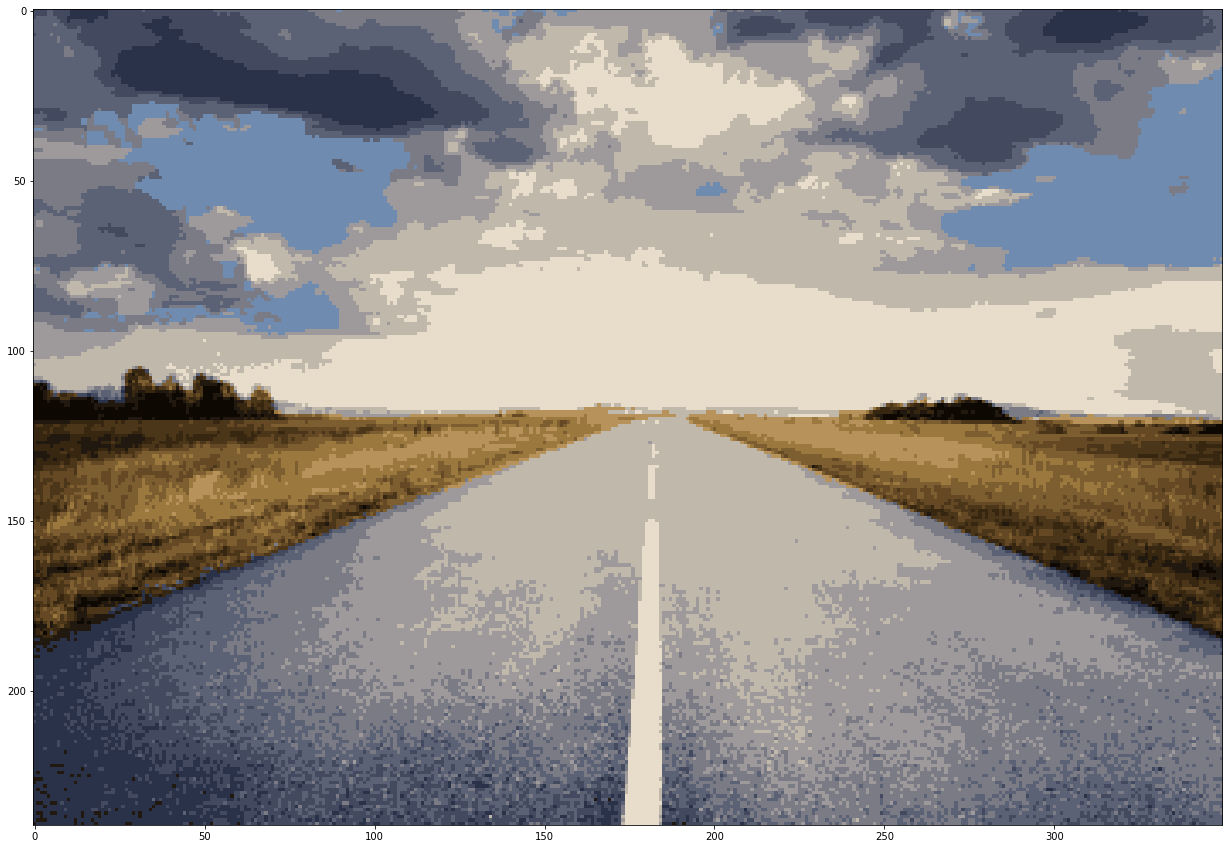

In [ ]:
show_image(k_mean_image)

In [ ]:
def smooth(image, centroids, kernel_size = 5):
    new_image = image.copy()
    width = image.shape[0]
    height = image.shape[1]
    offset = kernel_size // 2
    for x in range(offset, width - offset):
        for y in range(offset, height - offset):
            #new_image[x, y] =
            square = image[x-offset:x+offset + 1, y-offset:y+offset + 1]
            #print(square.shape)
            reshaped1 = square.reshape(kernel_size**2, 1, 3)
            #print(reshaped1.shape)
            mode = st.mode(reshaped1).mode
            # print(mode)
            new_image[x, y] = centroids[str(find_closest_centroid(mode[0], centroids))]
            # print(centroids[str(find_closest_centroid(mode[0], centroids))])
    return new_image[offset:width-offset+1, offset:height-offset+1]

In [ ]:
smooth_image = smooth(k_mean_image, clusters, k_means_smooth_kernel_size)


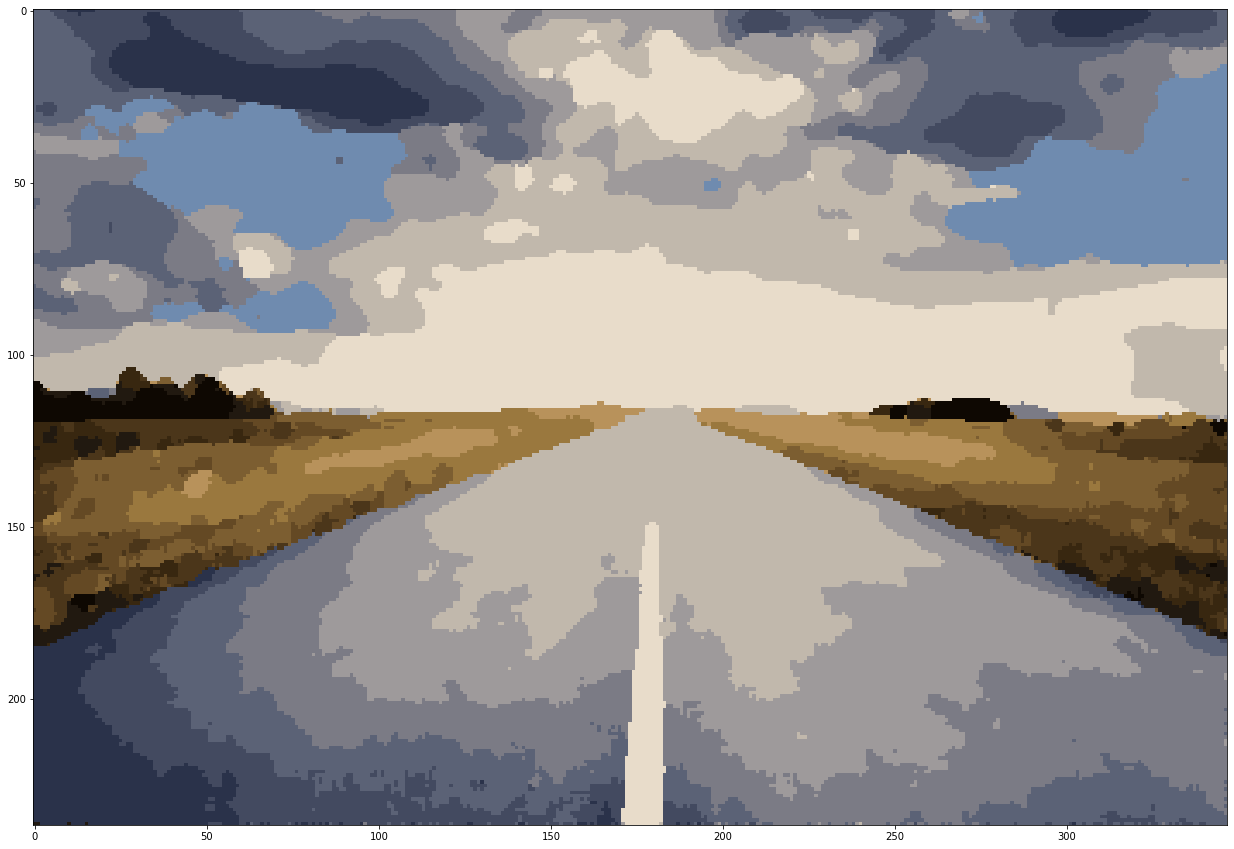

In [ ]:
show_image(smooth_image)

In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', cv2.cvtColor(smooth_image,cv2.COLOR_BGR2RGB))
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def convert_k_means_to_index(image, clusters):
    width = image.shape[0]
    height = image.shape[1]

    index_image = np.zeros((width, height))
    for x in range(0, width):
        for y in range(0, height):
            index_image[x,y] = find_closest_centroid(image[x,y], clusters)

    return index_image

In [ ]:
converted_smooth_image = smooth(k_mean_image, clusters, second_smooth_value_kernel_size)

smooth_index_image = convert_k_means_to_index(converted_smooth_image, clusters)

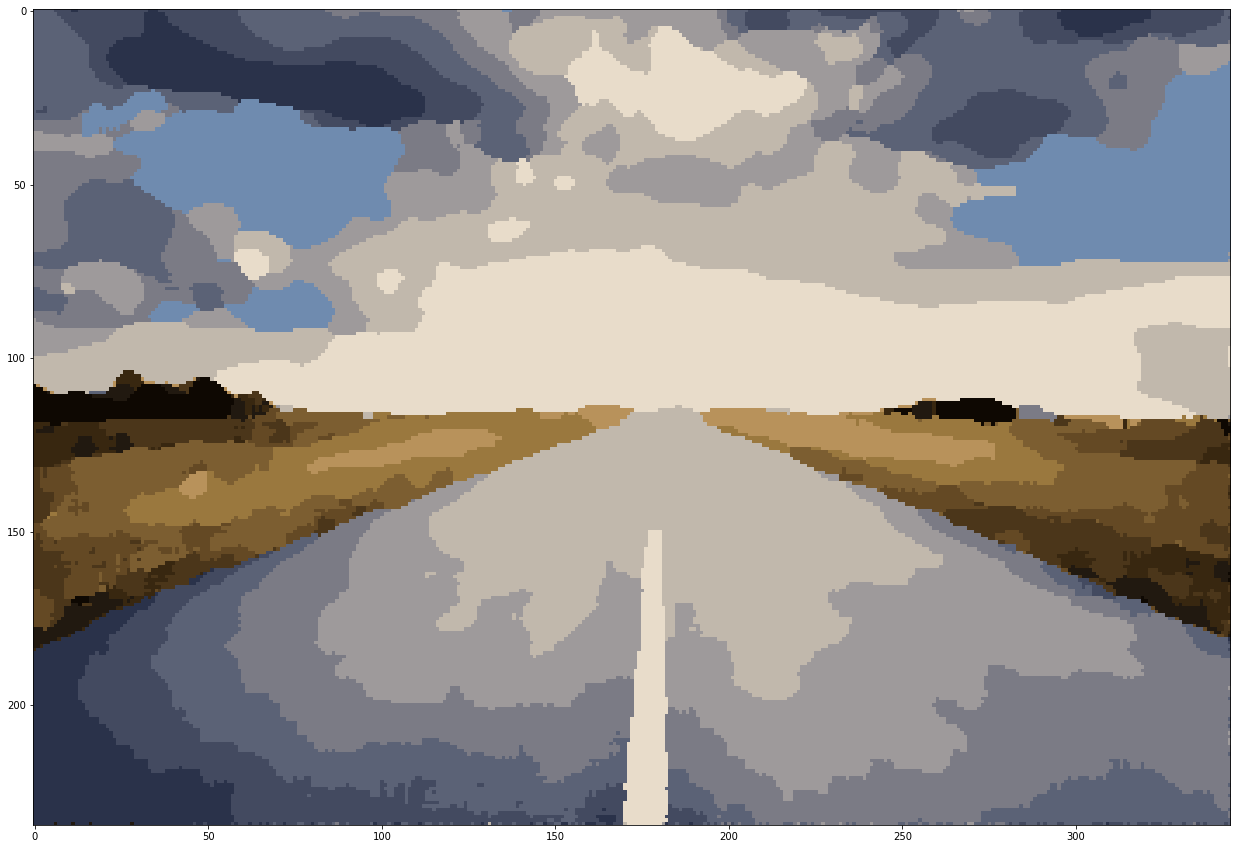

In [ ]:
show_image(converted_smooth_image)

In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', cv2.cvtColor(converted_smooth_image,cv2.COLOR_BGR2RGB))
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def outline(mat):
    xmax, ymax, _ = mat.shape
    outline_image = np.zeros((xmax, ymax))

    print(xmax, ymax, mat[0,0])
    for x in range(1, xmax - 1):
        for y in range (1, ymax - 1):
            pixel = mat[x, y]
            #if (pixel == mat[x-1,y]).all() or (pixel == mat[x+1,y]).all() or (pixel == mat[x, y-1]).all() or (pixel == mat[x, y+1]).all():
            #if pixel == mat[x+1, y] or pixel == mat[x-1, y] or pixel == mat[x, y+1] or pixel == mat[x, y-1]:
            if (pixel == np.array(mat[x-1:x+1, y-1:y+1])).all():
            #if (pixel == mat[x-1,y]).all() and (pixel == mat[x+1, y]).all() and (pixel == mat[x, y-1]).all() and (pixel == mat[x, y+1]).all():
                outline_image[x, y] = 255
            else:
                outline_image[x, y] = 0
    
    return outline_image

In [ ]:
outline_image = outline(converted_smooth_image)


235 345 [ 91  98 118]


In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', outline_image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def greyscale(image):
    greyscale_image = np.zeros((image.shape[0], image.shape[1]))

    for x in range (0, image.shape[0]):
        for y in range(0, image.shape[1]):
            greyscale_image[x, y] = (0.3 * image[x,y][0] + 0.59 * image[x,y][1] + 0.11 * image[x,y][2]) / np.max(image)
    
    return greyscale_image

In [ ]:
greyscale_image = greyscale(converted_smooth_image)

In [ ]:
def calculate_x_Sobel(matrix) -> float:
    return matrix[0,0] * (-1) + matrix[2,0] - 2 * matrix[0,1] + 2 * matrix[2,1] - matrix[0,2] + matrix[2,2]

In [ ]:
def calculate_y_Sobel(matrix) -> float:
    return matrix[0,0] * (-1) -2 * matrix[1,0] - matrix[2,0] +  matrix[0,2] + 2 * matrix[1,2] + matrix[2,2]

In [ ]:
def outline_Sobel(image):
    width = image.shape[0]
    height = image.shape[1]
    new_image = np.zeros((width, height))
    offset = 1
    for x in range(offset, width - offset):
        for y in range(offset, height - offset):
            x_sobel = calculate_x_Sobel(image[x-offset:x+offset+1, y-offset:y+offset+1])
            y_sobel = calculate_y_Sobel(image[x-offset:x+offset+1, y-offset:y+offset+1])
            #print(x_sobel, y_sobel, (x_sobel**2 + y_sobel**2)**0.5)
            new_image[x,y] = (x_sobel**2 + y_sobel**2)**0.5
    
    return new_image

In [ ]:
outline_image = outline_Sobel(greyscale_image)

In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', outline_image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def outline_more(image, Q = 0.2):
    width = image.shape[0]
    height = image.shape[1]
    result_image = np.zeros((width, height))
    for x in range(0, width):
        for y in range(0, height):
            if image[x,y] > Q:
                result_image[x,y] = 1
    
    return result_image

In [ ]:
outline_more_image = outline_more(outline_image)

In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', outline_more_image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def outline_regions(image):
    width = image.shape[0]
    height = image.shape[1]

    index_image = np.ones((width, height))
    for x in range(1, width):
        if (image[x, 0] != image[x-1, 0]).all():
            index_image[x, 0] = 0
        
        
    
    for y in range (1, height):
        if (image[0, y] != image[0, y-1]).all():
             index_image[0,y] = 0

    for x in range(1, width):
        for y in range(1, height):
            if ((image[x, y] != image[x-1, y]).all() or (image[x, y] != image[x, y-1]).all()) and (index_image[x-1,y] == 1 or index_image[x,y-1] == 1):
                index_image[x,y] = 0
       
    return index_image[:-1,:-1]

In [ ]:
counturs = outline_regions(converted_smooth_image)

In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', counturs)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def unite_image_with_countour(source_image, outline_image, clusters):
    width = outline_image.shape[0]
    height = outline_image.shape[1]
    offset = abs(source_image.shape[0] - width ) // 2
    print(outline_image.shape[0], source_image.shape[0], offset)
    result_image = source_image.copy()
    for x in range(offset, width - offset):
        for y in range(offset, height - offset):
            # print(x,y, outline_image)
            if outline_image[x - offset,y - offset] == 0:
                result_image[x,y] = np.array([0,0,0])


    return result_image[offset:-offset, offset:-offset]

In [ ]:
def unite_regions(image, n1, n2):
    image[image == int(n1)] = int(n2)
    # print(n1,n2,image)
    return image


In [ ]:
def add_regions(image):
    width = image.shape[0]
    height = image.shape[1]

    current_index = 0
    index_image = np.ones((width, height))
    for x in range(1, width):
        if image[x, 0] != image[x-1, 0]:
            current_index += 1
            
        index_image[x, 0] = int(current_index)
        
    print(current_index)

    
    for y in range (1, height):
        if image[0, y] != image[0, y-1]:
            current_index += 1
        index_image[0,y] = int(current_index)

    print(current_index)
    for x in range(1, width):
        for y in range(1, height):
            # print(image[x,y], image[x-1,y], image[x,y-1])
            if image[x, y] != image[x-1, y] and image[x, y] != image[x, y-1]:
                current_index += 1
                # print(x,y)
                index_image[x,y] = int(current_index)
            elif image[x, y] == image[x-1, y] and image[x, y] != image[x, y-1]:
                index_image[x,y] = int(index_image[x-1,y])
            elif image[x, y] == image[x, y-1] and image[x, y] != image[x-1, y]:
                index_image[x,y] = int(index_image[x,y-1])
            elif image[x, y] == image[x-1, y] and image[x, y] == image[x, y-1]:
                index_image[x,y] = int(index_image[x-1,y])
                index_image = unite_regions(index_image, index_image[x,y-1], index_image[x-1, y])
                # print(current_index, np.max(index_image.reshape(-1)))
       
    print(current_index)

    return index_image

In [ ]:
def convert_index_to_k_means(image, indexes, clusters):
    width = image.shape[0]
    height = image.shape[1]

    result_image = image.copy()
    for x in range(0, width):
        for y in range(0, height):
            result_image[x,y] = clusters[str(int(indexes[x,y]))]

    return result_image

In [ ]:
# converted_k_means_image = convert_index_to_k_means(smooth_image, index_image, clusters)

In [ ]:
# cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
# cv2.resizeWindow('custom window', 1060, 1000)
# cv2.imshow('custom window', cv2.cvtColor(converted_k_means_image,cv2.COLOR_BGR2RGB))
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

In [ ]:
# cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
# cv2.resizeWindow('custom window', 1060, 1000)
# cv2.imshow('custom window', cv2.cvtColor(converted_smooth_image,cv2.COLOR_BGR2RGB))
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

In [ ]:
regions_image = add_regions(smooth_index_image)

18
44
1726


In [ ]:
def reduce_regions_image(image):
    result_image = image.copy()
    width = image.shape[0]
    height = image.shape[1]
    regions = np.unique(regions_image.reshape(-1), axis=0)
    for region in regions:
        result_image[result_image == region] = result_image


In [ ]:
def smooth_regions(image, kernel_size = 5):
    new_image = image.copy()
    width = image.shape[0]
    height = image.shape[1]
    offset = kernel_size // 2
    for x in range(offset, width - offset):
        for y in range(offset, height - offset):
            #new_image[x, y] =
            square = image[x-offset:x+offset + 1, y-offset:y+offset + 1]
            #print(square.shape)
            reshaped1 = square.reshape(kernel_size**2, 1)
            #print(reshaped1.shape)
            mode = st.mode(reshaped1).mode
            # print(mode)
            new_image[x, y] = mode
            # print(centroids[str(find_closest_centroid(mode[0], centroids))])
    return new_image[offset:width-offset+1, offset:height-offset+1]

In [ ]:
smooth_regions_image = smooth_regions(regions_image)

C:\Users\Rybak\AppData\Local\Temp/ipykernel_3888/1162234940.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[x, y] = mode


In [ ]:
result = smooth_regions_image / np.max(smooth_regions_image) * 255

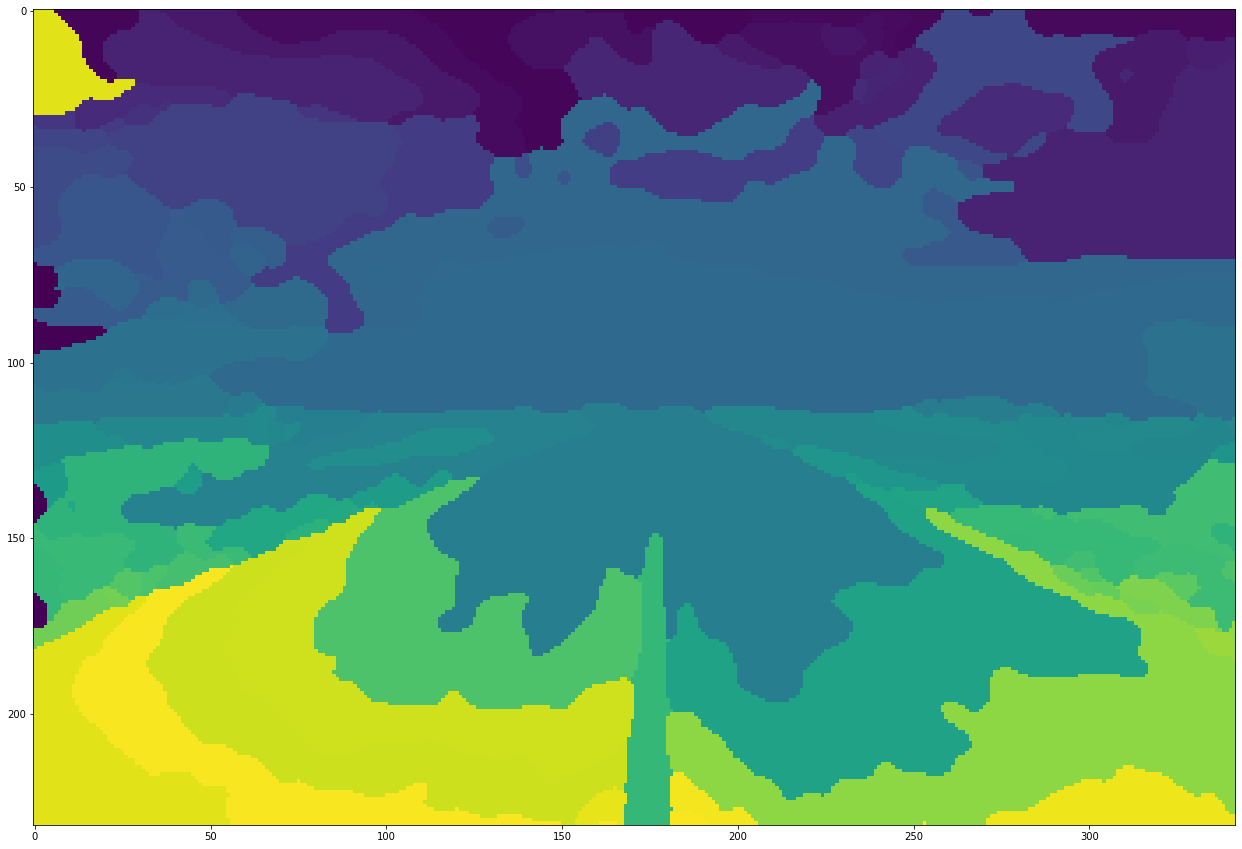

In [ ]:
show_image(result)

In [ ]:
counturs_1 = outline_regions(result)

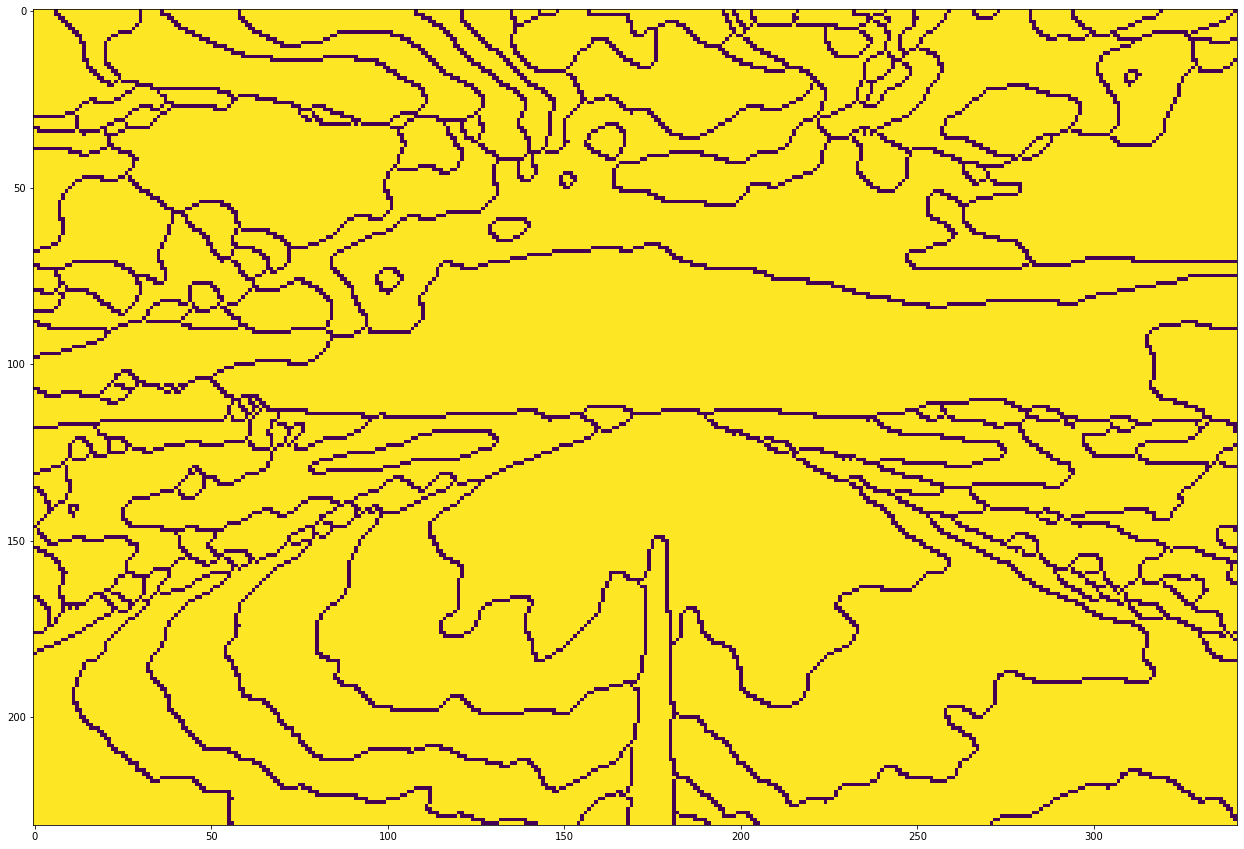

In [ ]:
show_image(counturs_1)

In [ ]:
def find_region_center(regions, region, index_image):
    width = regions.shape[0]
    height = regions.shape[1]
    x_result = 0
    y_result = 0
    count = 0
    cluster = -1
    for x in range(0, width):
        for y in range(0, height):
            if regions[x,y] == region:
                cluster = int(index_image[x,y])
                x_result += x
                y_result += y
                count += 1
                # if (count > 0):
                #     return (x,y), cluster
    if (count <= 10):
        return (0,0), cluster
    return (x_result / count, y_result / count), cluster

In [ ]:
def add_nums(image, index_image, regions):
    index_image = index_image[:-1, :-1]
    offset = abs(image.shape[0] - regions.shape[0]) // 2
    print(image.shape, index_image.shape, offset)
    result_image = image.copy()
    regions_list = np.unique(regions_image.reshape(-1), axis=0)
    for region in regions_list:
        center, cluster = find_region_center(regions, region, index_image)
        if (center[0] > 0 or center[1] > 0):
            result_image = cv2.putText(
            img = result_image,
            text = str(int(cluster) + 1),
            org = (int(center[1] + offset - 2), int(center[0] + offset + 2)),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.2,
            color = (0,0, 0),
            thickness = 1
            )
    
    return result_image

In [ ]:
counturs = outline_regions(converted_smooth_image)

In [ ]:
painted_unite_image = unite_image_with_countour(converted_smooth_image, counturs_1, clusters)

231 235 2


In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', cv2.cvtColor(painted_unite_image,cv2.COLOR_BGR2RGB))
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
painted_number_image = add_nums(painted_unite_image, smooth_index_image, smooth_regions_image)

(231, 341, 3) (234, 344) 0


In [ ]:
if (should_show_windows):
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.resizeWindow('custom window', 1060, 1000)
    cv2.imshow('custom window', cv2.cvtColor(painted_number_image,cv2.COLOR_BGR2RGB))
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [ ]:
def show_image_with_legend(image, clusters):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(12)
    for cluster_index in clusters:
        plt.plot(int(cluster_index), int(cluster_index), color = (clusters[cluster_index] / 255), label='colour ' + str(int(cluster_index) + 1), linewidth='7')

        plt.legend(fontsize=12, shadow=True, framealpha=1, facecolor='w', edgecolor='black', title='Legend', bbox_to_anchor=(1.2, 1))

    plt.imshow(image.astype(np.uint8))
    plt.show()

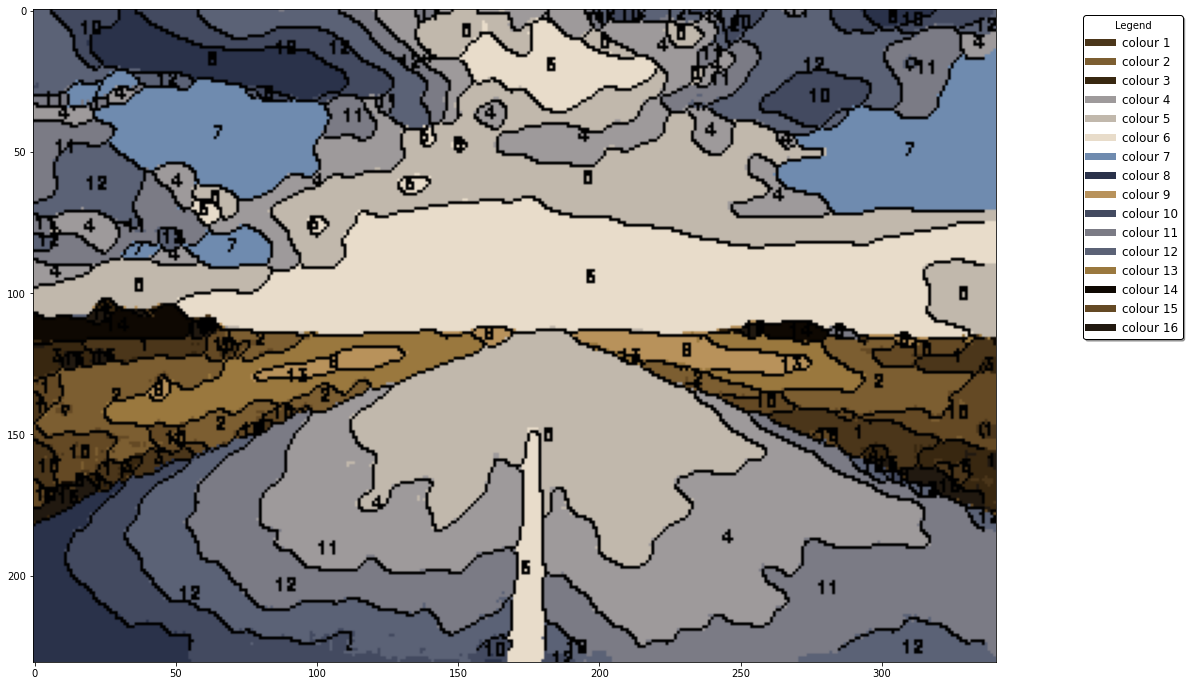

In [ ]:
show_image_with_legend(painted_number_image, clusters)

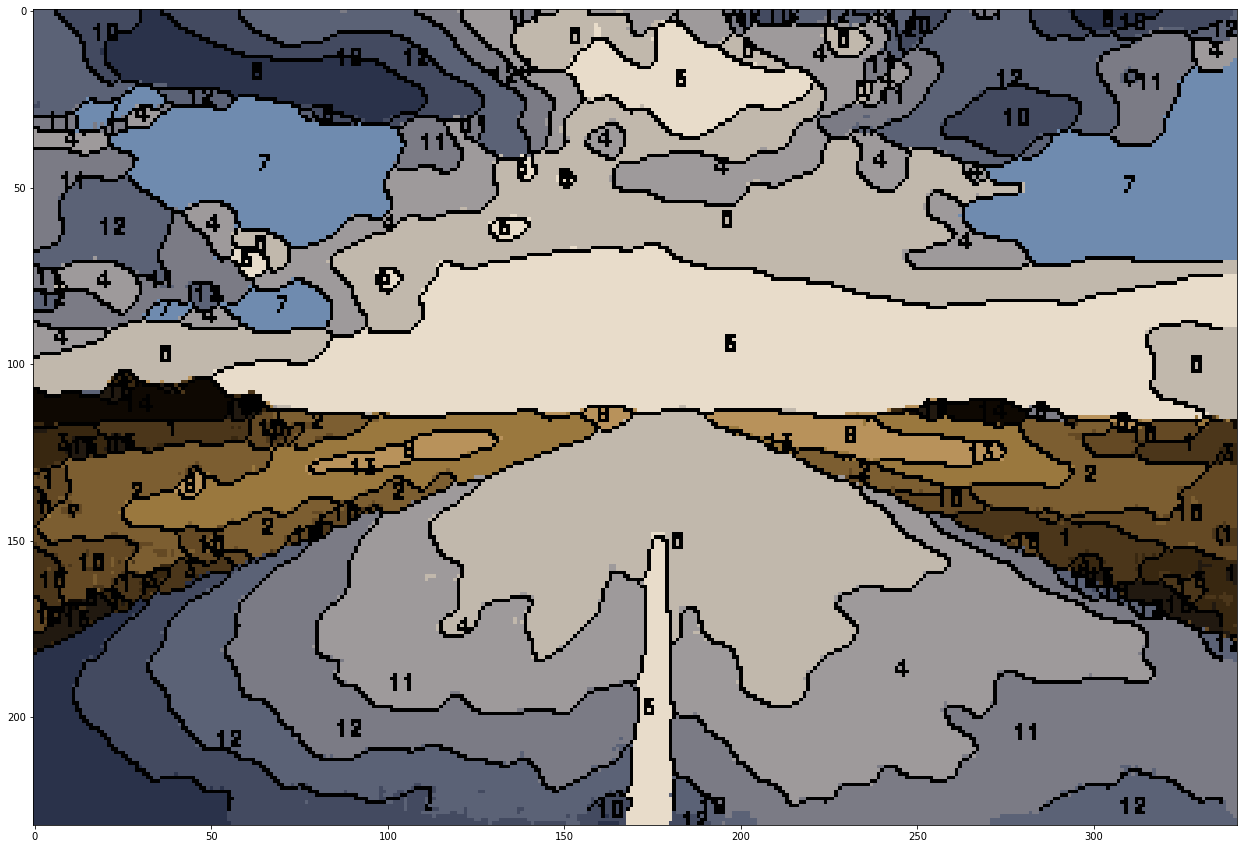

In [ ]:
show_image(painted_number_image)

In [ ]:
paint_by_number = add_nums(counturs_1, smooth_index_image, smooth_regions_image)

(231, 341) (234, 344) 0


In [ ]:
cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow('custom window', 1060, 1000)
cv2.imshow('custom window', paint_by_number)
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [ ]:
def add_nums_debug(image, index_image, regions):
    index_image = index_image[:-1, :-1]
    offset = abs(image.shape[0] - regions.shape[0]) // 2
    # print(image.shape, index_image.shape, offset)
    result_image = image.copy()
    regions_list = np.unique(regions_image.reshape(-1), axis=0)
    iterator = 0
    for region in regions_list:
        center, cluster = find_region_center(regions, region, index_image)
        if (center[0] > 0 or center[1] > 0):
            result_image = cv2.putText(
            img = result_image,
            text = str(int(cluster)),
            org = (int(center[1] + offset - 2), int(center[0] + offset + 2)),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 0.2,
            color = (0,255, 0),
            thickness = 1
            )

            if iterator % 20 == 0:

                show_image(result_image)
            iterator += 1

    show_image(result_image)
    return result_image

In [ ]:
image_path = 'Project_Results/' + image_name + '_painted_' + str(cluster_value) + '.jpg'

In [ ]:
cv2.imwrite(image_path, cv2.cvtColor(painted_number_image,cv2.COLOR_BGR2RGB))

True

In [ ]:
# debug_regions = add_nums_debug(result, smooth_index_image, smooth_regions_image)